<a href="https://colab.research.google.com/github/NickKar30/GM-HSE-AI-masters-course/blob/main/Hometasks/Base/GenDL_HT1_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание - 1 (базовая группа)

В этом домашнем задании вы потренируетесь решать задачу speech-to-text.

Вы не будете тренировать сложную архитектуру с нуля, а попробуете решить эту задачу, пройдя по пайплайну, в котором задача разбита на несколько простых шагов.

- В этом задании мы призываем вас по-максимуму использовать документацию моделей и получить опыт написания кода без заготовок

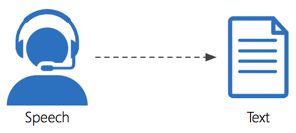

In [ ]:
!pip install --upgrade transformers datasets -q

In [ ]:
!pip install evaluate -q

In [ ]:
!pip install groq -q

In [ ]:
!pip install jiwer -q
!pip install torcheval

In [ ]:
from transformers import WhisperForConditionalGeneration, WhisperProcessor, AutoProcessor, \
        AutoModelForSpeechSeq2Seq, T5ForConditionalGeneration, pipeline, \
        AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainer, \
        Seq2SeqTrainingArguments, T5TokenizerFast, T5Tokenizer
import torch
import torchaudio
import pandas as pd
import numpy as np
import requests
import io
from tqdm import tqdm
import re
import os
from groq import Groq
from typing import List, Dict, Tuple
from datasets import Dataset, load_dataset
from huggingface_hub import login
import json
import evaluate
from torcheval.metrics import WordErrorRate
import string

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Шаг 1 (1 балл)

* Возьмите датасет https://disk.yandex.ru/d/v2Hipv7XG4fEDQ, содержащий русскоязычные аудиозаписи

* Примените модель [whisper-small](https://huggingface.co/openai/whisper-small) из HF для определения сказанного в аудио.

* Выведите результат работы модели для 10 случайных аудио из датасета

Не стесняйтесь пользоваться документацией и источниками знаний из интернета!

In [ ]:
def whisper_small(model, processor, dataset):
    forced_decoder_ids = processor.get_decoder_prompt_ids(language="russian", task="transcribe")
    transcriptions = []
    urls = []
    wavs = []
    srs = []

    for i in tqdm(range(len(dataset))):
        url = dataset[0][i]
        urls.append(url)
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        buffer = io.BytesIO(response.content)
        wav, sr = torchaudio.load(buffer)
        if sr != 16000:
            wav = torchaudio.functional.resample(wav, orig_freq=sr, new_freq=16000)
            sr = 16000
        wav = wav.numpy()
        input_features = processor(wav, sampling_rate=16000, return_tensors="pt").input_features.to(device)
        with torch.no_grad():
            predicted_ids = model.generate(input_features, forced_decoder_ids=forced_decoder_ids)
        transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)
        transcriptions.append(transcription[0].lower())
        wavs.append(wav)
        srs.append(sr)

    df = pd.DataFrame({
        'URL': urls,
        'wav': wavs,
        'sr': srs,
        'transcription': transcriptions
    })
    return df

In [ ]:
dataset = pd.read_csv('urls_normalized.tsv', header=None, sep='\t')
processor = WhisperProcessor.from_pretrained("openai/whisper-small", language="russian", task="transcribe")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")
model.to(device)
df = whisper_small(model, processor, dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/

In [ ]:
df = df.sample(frac=1.0).reset_index(drop=True)
df[:10]

,URL,wav,sr,transcription
0,http://storage.mds.yandex.net:80/get-voicetolo...,"[[0.0, 0.0, 0.0, 0.0, 3.0517578e-05, -3.051757...",16000,крепкий орешек.
1,http://storage.mds.yandex.net:80/get-voicetolo...,"[[0.0, 0.0, 0.0, 3.0517578e-05, 0.0, -3.051757...",16000,фернандо баторо
2,http://storage.mds.yandex.net:80/get-voicetolo...,"[[-3.436249e-06, -9.915505e-06, 2.4899032e-06,...",16000,аладдина.
3,http://storage.mds.yandex.net:80/get-voicetolo...,"[[3.0517578e-05, 0.0, 0.0, 0.0, 3.0517578e-05,...",16000,жан-поль-сартер
4,http://storage.mds.yandex.net:80/get-voicetolo...,"[[-2.0807556e-07, 9.709505e-06, 5.6679696e-06,...",16000,город бога
5,http://storage.mds.yandex.net:80/get-voicetolo...,"[[1.54905e-07, 2.5355005e-06, -2.7489548e-07, ...",16000,брюс springsteam
6,http://storage.mds.yandex.net:80/get-voicetolo...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0517578e-05,...",16000,"бабель исаак, эммануи лавич."
7,http://storage.mds.yandex.net:80/get-voicetolo...,"[[-0.14007568, -0.09539795, -0.051849365, 0.10...",16000,бред пит
8,http://storage.mds.yandex.net:80/get-voicetolo...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -3.051757...",16000,умница уилл хантинг
9,http://storage.mds.yandex.net:80/get-voicetolo...,"[[-6.685998e-06, 7.918848e-06, 9.278497e-06, 1...",16000,смоки робинсон


## Шаг 2 (1 балл)

Текст распознается с ошибками.
Попробуйте исправить ошибки с помощью готовой (предобученной) модели spell correction.

Выведите на экран 10 текстов с предыдущего шага и их исправления с помощью модели https://huggingface.co/UrukHan/t5-russian-spell.

In [ ]:
MODEL_NAME = 'UrukHan/t5-russian-spell'
MAX_INPUT = 256

tokenizer = T5TokenizerFast.from_pretrained(MODEL_NAME)
model2 = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
task_prefix = "Spell correct: "
encoded = tokenizer(
  [task_prefix + sequence for sequence in df.transcription],
  padding="longest",
  max_length=MAX_INPUT,
  truncation=True,
  return_tensors="pt",
)

with torch.no_grad():
    predicts = model2.generate(
        encoded.input_ids
    )

corrected_texts = tokenizer.batch_decode(predicts, skip_special_tokens=True)

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/1.00M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

In [ ]:
corrected_texts = [text.lower() for text in corrected_texts]
df['correction'] = corrected_texts
df.to_csv('whisper-small.csv', encoding='utf-8', index=False)
df[:10]

,URL,wav,sr,transcription,correction
0,http://storage.mds.yandex.net:80/get-voicetolo...,"[[0.0, 0.0, 0.0, 0.0, 3.0517578e-05, -3.051757...",16000,крепкий орешек.,крепкий орешек.
1,http://storage.mds.yandex.net:80/get-voicetolo...,"[[0.0, 0.0, 0.0, 3.0517578e-05, 0.0, -3.051757...",16000,фернандо баторо,фернандо баторо
2,http://storage.mds.yandex.net:80/get-voicetolo...,"[[-3.436249e-06, -9.915505e-06, 2.4899032e-06,...",16000,аладдина.,аладдина.
3,http://storage.mds.yandex.net:80/get-voicetolo...,"[[3.0517578e-05, 0.0, 0.0, 0.0, 3.0517578e-05,...",16000,жан-поль-сартер,жан-поль-сартер
4,http://storage.mds.yandex.net:80/get-voicetolo...,"[[-2.0807556e-07, 9.709505e-06, 5.6679696e-06,...",16000,город бога,город бога
5,http://storage.mds.yandex.net:80/get-voicetolo...,"[[1.54905e-07, 2.5355005e-06, -2.7489548e-07, ...",16000,брюс springsteam,брюс (springsteam)
6,http://storage.mds.yandex.net:80/get-voicetolo...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0517578e-05,...",16000,"бабель исаак, эммануи лавич.","бабель исаак, эммануэль лавич."
7,http://storage.mds.yandex.net:80/get-voicetolo...,"[[-0.14007568, -0.09539795, -0.051849365, 0.10...",16000,бред пит,"бред, пит."
8,http://storage.mds.yandex.net:80/get-voicetolo...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -3.051757...",16000,умница уилл хантинг,умница уилл хантинг.
9,http://storage.mds.yandex.net:80/get-voicetolo...,"[[-6.685998e-06, 7.918848e-06, 9.278497e-06, 1...",16000,смоки робинсон,смоки робинсон


## Шаг 3 (2 балла)

Соберите данные для дообучения модели выше. Для дообучения мы предлагаем вам использовать бесплатный api Groq: https://console.groq.com/docs/quickstart

Разберитесь с тем как пользоваться api (мы немного поможем вам с этим кодом ниже) и с его помощью соберите датасет (можно в несколько запросов).

- **0.5 балла** ставится за сбор датасета размером >1000 строк и сохранение в локальный файл/файлы

- **еще 0.5 балла** ставится за [создание huggingface dataset](https://huggingface.co/docs/datasets/create_dataset) (через использование библиотек datasets и huggingface) и [сохранение собранного датасета напрямую в HuggingFace](https://huggingface.co/docs/datasets/upload_dataset)

- **еще 1 балл** ставится за сбор датасета размером >1000 строк, на котором путем дообучения получится увеличить качество исправления опечаток в поставленной задаче (см. шаг 6) по сравнению с качеством прогноза той же, но предобученной модели

P.S. Если у Вас нет VPN, то можете воспользоваться другой LLM на Ваш выбор (можно, например, этим https://ollama.com/).

In [ ]:
client = Groq(api_key=os.environ.get("GROQ_API_KEY"))

In [ ]:
def parse_spelling_pairs(content: str) -> List[Dict[str, str]]:
    pairs = []
    if content == "":
        return None

    lines = content.strip().split('\n')
    for line in lines:
        line = line.strip()
        m = re.search(r'([а-яё\s]+)\s*&\s*([а-яё\s]+)', line, re.IGNORECASE)
        if m:
            try:
                wrong, correct = m.groups()
                wrong = wrong.strip().lower()
                correct = correct.strip().lower()
                if wrong != correct and len(wrong) > 2 and len(correct) > 2:
                    pairs.append({'input': wrong, 'target': correct})
            except:
                print(line)
                pairs = []

    return pairs

In [ ]:
def generate_spelling_pairs(category, batch_size = 250):
    prompt = f"""Сгенерируй {batch_size} реальных примеров распространённых ошибок в русской орфографии, связанных с {category}.
    Формат каждой строки строго: <ошибочное слово> & <правильное слово>
    Примеры:
    зделать & сделать
    бесвкусный & безвкусный
    безимяный & безымянный

    расписание & расписание (если ошибки нет, не включай строку)"""

    try:
        response = client.chat.completions.create(
            messages=[{"role": "user", "content": prompt}],
            model="llama-3.3-70b-versatile",
        )
        content = response.choices[0].message.content
        print("Model: llama-3.3-70b-versatile")
    except Exception as e:
        try:
            response = client.chat.completions.create(
                messages=[{"role": "user", "content": prompt}],
                model="llama-3.1-8b-instant",
            )
            content = response.choices[0].message.content
            print("Model: llama-3.1-8b-instant")
        except Exception as e:
            response = client.chat.completions.create(
                messages=[{"role": "user", "content": prompt}],
                model="DeepSeek-R1-Distill-Llama-70B",
            )
            content = response.choices[0].message.content

            print("Model: DeepSeek-R1-Distill-Llama-70B")
    # print(content)
    return parse_spelling_pairs(content)


In [ ]:
def remove_duplicates(pairs: List[Dict[str, str]]) -> List[Dict[str, str]]:
    """Удаляет дубликаты из списка пар."""
    seen = set()
    unique_pairs = []

    for pair in pairs:
        key = (pair['input'], pair['target'])
        if key not in seen:
            seen.add(key)
            unique_pairs.append(pair)

    return unique_pairs

In [ ]:
all_pairs = []
categories = [
    "ошибками в приставках (бес/без, рас/раз, пре/при)",
    "ошибками в суффиксах (-н-/-нн-, -ск-/-к-)",
    "правописанием -тся/-ться в глаголах",
    "правописанием 'не' слитно или раздельно с разными частями речи",
    "правописанием 'о' и 'а' в корнях (-лаг-/-лож-, -рос-/-раст-)",
    "правописанием 'и', 'ы' после приставок на согласный",
    "правописанием мягкого знака после шипящих",
    "ошибками в склонении числительных"
]
i = 0
batch_size=250
while len(all_pairs) < 1000:
    print(f"Собрано {len(all_pairs)} пар")
    print(f"Категория {categories[i]}")
    new_pairs = generate_spelling_pairs(categories[i], batch_size)
    if new_pairs is None:
        break;
    all_pairs.extend(new_pairs)
    all_pairs = remove_duplicates(all_pairs)
    print(f"Получено {len(new_pairs)} новых пар, уникальных: {len(all_pairs)}")
    i += 1
    if i >= len(categories):
        i = 0

Собрано 0 пар
Категория ошибками в приставках (бес/без, рас/раз, пре/при)
Model: llama-3.3-70b-versatile
Получено 250 новых пар, уникальных: 64
Собрано 64 пар
Категория ошибками в суффиксах (-н-/-нн-, -ск-/-к-)
Model: llama-3.3-70b-versatile
Получено 6 новых пар, уникальных: 70
Собрано 70 пар
Категория правописанием -тся/-ться в глаголах
Model: llama-3.3-70b-versatile
Получено 19 новых пар, уникальных: 89
Собрано 89 пар
Категория правописанием 'не' слитно или раздельно с разными частями речи
Model: llama-3.3-70b-versatile
Получено 11 новых пар, уникальных: 99
Собрано 99 пар
Категория правописанием 'о' и 'а' в корнях (-лаг-/-лож-, -рос-/-раст-)
Model: llama-3.3-70b-versatile
Получено 4 новых пар, уникальных: 103
Собрано 103 пар
Категория правописанием 'и', 'ы' после приставок на согласный
Model: llama-3.3-70b-versatile
Получено 51 новых пар, уникальных: 116
Собрано 116 пар
Категория правописанием мягкого знака после шипящих
Model: llama-3.3-70b-versatile
Получено 120 новых пар, уникальн

In [ ]:
df = pd.DataFrame(all_pairs)
df.to_csv('word_pairs.csv', encoding='utf-8')
login()
dataset = Dataset.from_pandas(df)
dataset.push_to_hub("Zharova/word-pairs-dataset")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              : 100%|##########| 23.0kB / 23.0kB            

CommitInfo(commit_url='https://huggingface.co/datasets/Zharova/word-pairs-dataset/commit/27dec2beaec5d01ca068681e89958909250cd3fb', commit_message='Upload dataset', commit_description='', oid='27dec2beaec5d01ca068681e89958909250cd3fb', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Zharova/word-pairs-dataset', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Zharova/word-pairs-dataset'), pr_revision=None, pr_num=None)

## Шаг 4 (2 балла)

Дообучите модель выше или любую другую модель, которая вам нравится, на собранных данных и протестируйте ее на нескольких ошибочно распознанных whisper-small моделью аудио. Дообучение мы разбирали на семинаре - можете посмотреть, как мы это делали там.

Для оценки качества результата выведите на экран 10 текстов с предыдущего шага и их исправления с помощью модели.

- Вы можете воспользовать структурой, предложенной в ячейке ниже, а можете написать код по-своему.

In [ ]:
def preprocess_function(examples):
    inputs = examples['input']
    targets = examples['target']

    model_inputs = tokenizer(
        inputs,
        max_length=MAX_INPUT,
        truncation=True,
        padding=True
    )

    labels = tokenizer(
        targets,
        max_length=MAX_OUTPUT,
        truncation=True,
        padding=True
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
# Модель
REPO = "word-pairs-dataset"
MAX_INPUT = 256
MAX_OUTPUT = 256
MODEL_NAME = "UrukHan/t5-russian-spell"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME).to(device)
BATCH_SIZE = 8
model.config.max_length = MAX_OUTPUT

# Загружаем свой CSV с парами (input → target)
data = load_dataset("Zharova/word-pairs-dataset")
train_data = data['train']

# Токенизация
tokenized_train = train_data.map(preprocess_function, batched=True)

# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True
)

# Аргументы обучения
training_args = Seq2SeqTrainingArguments(
    output_dir = REPO,
    eval_strategy='no',
    eval_steps=5000,
    save_steps=5000,
    num_train_epochs=1,
    predict_with_generate=True,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    fp16=True,
    save_total_limit=2,
    weight_decay=0.005
)

# Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

# Запускаем обучение
trainer.train()

# Сохраняем дообученную модель
trainer.save_model("./word-pairs-model")
tokenizer.save_pretrained("./word-pairs-model")

/tmp/ipython-input-855502069.py:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3922: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 256}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


('./word-pairs-model/tokenizer_config.json',
 './word-pairs-model/special_tokens_map.json',
 './word-pairs-model/spiece.model',
 './word-pairs-model/added_tokens.json',
 './word-pairs-model/tokenizer.json')

Примените дообученную модель. Как раз здесь для оценки качества результата выведите на экран 10 текстов с предыдущего шага и их исправления с помощью модели.

In [ ]:
# Загружаем дообученную модель
model_path = "./word-pairs-model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
df = pd.read_csv('whisper-small.csv')

# Применение модели
test_texts = df['transcription'].tolist()
task_prefix = "Spell correct: "
encoded = tokenizer(
  [task_prefix + sequence for sequence in df.transcription],
  padding="longest",
  max_length=MAX_INPUT,
  truncation=True,
  return_tensors="pt",
)

with torch.no_grad():
    predicts = model.generate(
        encoded.input_ids
    )

corrected_texts = tokenizer.batch_decode(predicts, skip_special_tokens=True)
corrected_texts = [text.lower() for text in corrected_texts]
df["my_dataset_correction"] = corrected_texts

In [ ]:
df.to_csv('whisper-small_my_dataset.csv', encoding='utf-8', index=False)
df[:10]

,URL,wav,sr,transcription,correction,my_dataset_correction
0,http://storage.mds.yandex.net:80/get-voicetolo...,[[-3.5851951e-07 3.9208467e-06 -2.8187169e-06...,16000,отступники.,отступники.,отступники
1,http://storage.mds.yandex.net:80/get-voicetolo...,[[-6.5586420e-07 -8.9415480e-06 -3.6037425e-06...,16000,ледниковый период,ледниковый период,ледниковый период
2,http://storage.mds.yandex.net:80/get-voicetolo...,[[-4.0442374e-06 -8.6535865e-06 2.7339472e-06...,16000,унесённый ветром.,унесённый ветром.,унесённый ветром
3,http://storage.mds.yandex.net:80/get-voicetolo...,[[-3.0517578e-05 4.2724609e-04 8.5449219e-04...,16000,мой отец и мой сын,мой отец и мой сын.,мой отец и мой сын
4,http://storage.mds.yandex.net:80/get-voicetolo...,[[ 0.0000000e+00 0.0000000e+00 0.0000000e+00...,16000,фернандо баторо,фернандо баторо,фернандо барто
5,http://storage.mds.yandex.net:80/get-voicetolo...,[[0. 0. 0. ... 0.01095...,16000,угладиатор,углудиатор,угладиатор
6,http://storage.mds.yandex.net:80/get-voicetolo...,[[ 1.30933742e-07 1.50141059e-05 3.03998131e...,16000,унесенные ветром,унесенные ветром.,унесенные ветром
7,http://storage.mds.yandex.net:80/get-voicetolo...,[[-3.0517578e-05 0.0000000e+00 0.0000000e+00...,16000,криминальная чтива.,криминальная чтива.,криминальная жизнь
8,http://storage.mds.yandex.net:80/get-voicetolo...,[[-6.6859980e-06 7.9188476e-06 9.2784967e-06...,16000,смоки робинсон,смоки робинсон,смоки робинсон
9,http://storage.mds.yandex.net:80/get-voicetolo...,[[ 3.0406350e-06 -9.8609034e-06 8.2309396e-07...,16000,жулианна мур,джулианна мур,жюлианна мур


## Шаг 5 (1 балл)

Время считать метрики и возвращаться к дообучению модели по необходимости. В этом шаге мы оцениваем только выполнение задания, а не значения метрик.

a) [Здесь](https://disk.yandex.ru/d/SPJU3lCt_cMDcw) лежат правильные ответы почти на все аудио - считайте метрики только для аудио, для которых мы дали вам ответы. Посчитайте [WER](https://docs.pytorch.org/torcheval/main/generated/torcheval.metrics.WordErrorRate.html) для модели whisper-small.

б) Посчитайте WER для whisper-small + исправление опечаток предобученной моделью (модель выберите самостоятельно!)

в) Посчитайте WER для whisper-small + дообученная Вами модель (данные для дообучения и модель выберите самостоятельно!)

In [ ]:
def calculate_wer(references, predictions):
    total_wer = 0
    count = 0

    for ref, pred in zip(references, predictions):
        clean_text = pred.translate(str.maketrans('', '', string.punctuation))
        wer_metric = WordErrorRate()
        wer_metric.update([clean_text.strip()], [ref])
        total_wer += wer_metric.compute()
        count += 1

    return total_wer / count if count > 0 else 0

In [ ]:
def compute_wer(df, prediction_column):
    with open('result_array.json', 'r', encoding='utf-8') as f:
        ground_truth_data = json.load(f)
    ground_truth_dict = {item['url']: item['text'] for item in ground_truth_data}
    references = []
    predictions = []

    for idx, row in df.iterrows():
        url = row['URL']
        if url in ground_truth_dict:
            references.append(ground_truth_dict[url])
            predictions.append(row[prediction_column])

    return calculate_wer(references, predictions)

In [ ]:
df = pd.read_csv('whisper-small_my_dataset.csv')
wer_whisper_small = compute_wer(df, 'transcription')
wer_model = compute_wer(df, 'correction')
wer_my = compute_wer(df, 'my_dataset_correction')

In [ ]:
print(f"Модель Whisper-small: WER={wer_whisper_small}")
print(f"Модель Whisper-small + t5-russian-spell: WER={wer_model}")
print(f"Модель Whisper-small + t5-russian-spell + мой датасет: WER={wer_my}")

Модель Whisper-small: WER=0.4388640820980072
Модель Whisper-small + t5-russian-spell: WER=0.4423362910747528
Модель Whisper-small + t5-russian-spell + мой датасет: WER=0.4386160373687744


## Шаг 6 (3 балла)

В этом шаге предлагаем вам провести максимум рисерча и экспериментов для наиболее качественного решения задачи (в бесплатном google colab, без привлечения дополнительных мощностей)

* Поищите предобученные модели, применение которых для задачи speech-to-text дает меньше опечаток (меньше WER)

* Протестируйте несколько spell-correction моделей и сделайте выводы какая из них лучше (с точки зрения WER)

* Возьмите лучшую из найденных моделей и попытайтесь улучшить ее через шаг 4, как делали ранее. Попробуйте немного изменить обучение в шаге 4, чтобы добиться еще более хороших результатов (изменить данные/гиперпараметры и т.п.) и проведите соответствующий эксперимент. Объясните почему ваша модификация шага 4 теоретически может улучшить результаты и сделайте выводы о том, получилось ли улучшить качество (если нет, то предположите почему).

### Модель whisper-large-v3-turbo

In [ ]:
def process_audio_urls(urls):
    results = []
    for url in urls:
        try:
            response = requests.get(url, timeout=30)
            response.raise_for_status()
            buffer = io.BytesIO(response.content)
            wav, sr = torchaudio.load(buffer)
            if wav.shape[0] > 1:
                wav = wav.mean(dim=0, keepdim=True)
            if sr != 16000:
                wav = torchaudio.functional.resample(wav, orig_freq=sr, new_freq=16000)
            wav = wav.numpy().squeeze()

            result = pipe(wav, generate_kwargs={
                    "language": "russian",
                    "task": "transcribe"
                })
            results.append(result["text"].lower())
        except Exception as e:
            print(f"Error processing {url}: {e}")
            results.append("")

    return results

In [ ]:
dataset = pd.read_csv('whisper-small_my_dataset.csv')
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
model_id = "openai/whisper-large-v3-turbo"
model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
)
model.to(device)
processor = AutoProcessor.from_pretrained(model_id)
pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    torch_dtype=torch_dtype,
    device=device,
    batch_size=8
)
urls = dataset["URL"].tolist()
transcriptions_turbo = process_audio_urls(urls)

config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!
Device set to use cuda
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https:

In [ ]:
result_df = pd.DataFrame(dataset["URL"].copy())
corrected_texts_turbo = [text.lower() for text in transcriptions_turbo]
result_df["transcriptions_turbo"] = corrected_texts_turbo
result_df.head(10)

,URL,transcriptions_turbo
0,http://storage.mds.yandex.net:80/get-voicetolo...,отступники.
1,http://storage.mds.yandex.net:80/get-voicetolo...,ледниковый период
2,http://storage.mds.yandex.net:80/get-voicetolo...,унесённый ветром
3,http://storage.mds.yandex.net:80/get-voicetolo...,мой отец и мой сын.
4,http://storage.mds.yandex.net:80/get-voicetolo...,фернандо батаро
5,http://storage.mds.yandex.net:80/get-voicetolo...,гладиатор
6,http://storage.mds.yandex.net:80/get-voicetolo...,«унесенные ветром».
7,http://storage.mds.yandex.net:80/get-voicetolo...,криминальное чтиво
8,http://storage.mds.yandex.net:80/get-voicetolo...,смоки робинсон
9,http://storage.mds.yandex.net:80/get-voicetolo...,джулианна мур


In [ ]:
wer_turbo = compute_wer(result_df, 'transcriptions_turbo')
print(f"Модель whisper-large-v3-turbo: WER={wer_turbo}")

Модель whisper-large-v3-turbo: WER=0.1940724104642868


whisper-large-v3-turbo лучше чем whisper-small

### сointegrated/rut5-base-multitask и UrukHan/t5-russian-spell для whisper-large-v3

In [ ]:
MODEL_NAME = 'cointegrated/rut5-base-multitask'
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
model2 = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
MAX_INPUT = 256
MAX_OUTPUT = 256
encoded = tokenizer(
  [sequence for sequence in result_df.transcriptions_turbo],
  padding="longest",
  max_length=MAX_INPUT,
  truncation=True,
  return_tensors="pt",
)

with torch.no_grad():
    predicts = model2.generate(
        encoded.input_ids
    )

corrected_texts = tokenizer.batch_decode(predicts, skip_special_tokens=True)

tokenizer_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/828k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/977M [00:00<?, ?B/s]

In [ ]:
MODEL_NAME = 'UrukHan/t5-russian-spell'

tokenizer = T5TokenizerFast.from_pretrained(MODEL_NAME)
model2 = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
task_prefix = "Spell correct: "
encoded = tokenizer(
  [task_prefix + sequence for sequence in result_df.transcriptions_turbo],
  padding="longest",
  max_length=MAX_INPUT,
  truncation=True,
  return_tensors="pt",
)

with torch.no_grad():
    predicts = model2.generate(
        encoded.input_ids
    )

corrected_texts_t5 = tokenizer.batch_decode(predicts, skip_special_tokens=True)

In [ ]:
corrected_texts = [text.lower() for text in corrected_texts]
corrected_texts_t5 = [text.lower() for text in corrected_texts_t5]
result_df['rut5'] = corrected_texts
result_df['t5'] = corrected_texts_t5
result_df.to_csv('whisper-small-rut5_my_dataset.csv', encoding='utf-8', index=False)
result_df[:10]

,URL,transcriptions_turbo,rut5,t5
0,http://storage.mds.yandex.net:80/get-voicetolo...,отступники.,отступники - отступники.,отступники.
1,http://storage.mds.yandex.net:80/get-voicetolo...,ледниковый период,ледниковый ледниковый ледниковый ледниковый ле...,ледниковый период
2,http://storage.mds.yandex.net:80/get-voicetolo...,унесённый ветром,ветром.,унесённый ветром.
3,http://storage.mds.yandex.net:80/get-voicetolo...,мой отец и мой сын.,это мой отец и мой сын.,мой отец и мой сын.
4,http://storage.mds.yandex.net:80/get-voicetolo...,фернандо батаро,батаро батаро.,фернандо батаро
5,http://storage.mds.yandex.net:80/get-voicetolo...,гладиатор,это я гладяатор.,гладиатор.
6,http://storage.mds.yandex.net:80/get-voicetolo...,«унесенные ветром».,ветер и ветер.,"""унесенные ветром""."
7,http://storage.mds.yandex.net:80/get-voicetolo...,криминальное чтиво,историческое чтиво.,криминалистическое чтиво
8,http://storage.mds.yandex.net:80/get-voicetolo...,смоки робинсон,что такое роб?,смоки робинсон
9,http://storage.mds.yandex.net:80/get-voicetolo...,джулианна мур,это джулианна мур.,джулианна мур


In [ ]:
wer_rut5 = compute_wer(result_df, 'rut5')
wer_t5 = compute_wer(result_df, 't5')

print(f"cointegrated/rut5-base-multitask для whisper-large-v3: WER={wer_rut5}")
print(f"t5-russian-spell для whisper-large-v3: WER={wer_t5}")

cointegrated/rut5-base-multitask для whisper-large-v3: WER=1.2225693464279175
t5-russian-spell для whisper-large-v3: WER=0.2201140969991684


t5-russian-spell дал лучший результат

### t5-russian-spell для whisper-large-v3-turbo с моими данными

In [ ]:
# Модель
REPO = "word-pairs-dataset"
MAX_INPUT = 256
MAX_OUTPUT = 256
MODEL_NAME = "UrukHan/t5-russian-spell"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME).to(device)
BATCH_SIZE = 8
model.config.max_length = MAX_OUTPUT

# Загружаем свой CSV с парами (input → target)
data = load_dataset("Zharova/word-pairs-dataset")
train_data = data['train']

# Токенизация
tokenized_train = train_data.map(preprocess_function, batched=True)

# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True
)

# Аргументы обучения
training_args = Seq2SeqTrainingArguments(
    output_dir = REPO,
    eval_strategy='no',
    num_train_epochs=1,
    predict_with_generate=True,
    per_device_train_batch_size=BATCH_SIZE,
    fp16=True,
    learning_rate=5e-5
)

# Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

# Запускаем обучение
trainer.train()

# Сохраняем дообученную модель
trainer.save_model("./word-pairs-model")
tokenizer.save_pretrained("./word-pairs-model")

/tmp/ipython-input-3965029806.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3922: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 256}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


('./word-pairs-model/tokenizer_config.json',
 './word-pairs-model/special_tokens_map.json',
 './word-pairs-model/spiece.model',
 './word-pairs-model/added_tokens.json',
 './word-pairs-model/tokenizer.json')

In [ ]:
# Загружаем дообученную модель
model_path = "./word-pairs-model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)

# Применение модели
task_prefix = "Spell correct: "
encoded = tokenizer(
  [task_prefix + sequence for sequence in result_df.transcriptions_turbo],
  padding="longest",
  max_length=MAX_INPUT,
  truncation=True,
  return_tensors="pt",
)

with torch.no_grad():
    predicts = model.generate(
        encoded.input_ids
    )

corrected_texts = tokenizer.batch_decode(predicts, skip_special_tokens=True)
corrected_texts = [text.lower() for text in corrected_texts]
result_df["my_dataset_correction"] = corrected_texts

In [ ]:
wer_my = compute_wer(result_df, 'my_dataset_correction')

print(f"Модель whisper-large-v3-turbo: WER={wer_turbo}")
print(f"t5-russian-spell для whisper-large-v3: WER={wer_t5}")
print(f"t5-russian-spell для whisper-large-v3 c моими данными: WER={wer_my}")

Модель whisper-large-v3-turbo: WER=0.1940724104642868
t5-russian-spell для whisper-large-v3: WER=0.2201140969991684
t5-russian-spell для whisper-large-v3 c моими данными: WER=0.243923619389534


Самый лучший показатель получен с использование только модели whisper-large-v3-turbo без корректировки результатов, улучшить результаты не получилось